# Desription

+ Simulation of timing synchronization using square timing recovery
+ QPSK symbols are sampled, pulse shaped and transmitted
+ Uniformly distributed frequency distortion is added, before frequency is estimated using algorithm as discussed in the lecture

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(28, 8) )

# Initialization

### Parameters

In [3]:
# number of symbols per sequence/packet
n_symb = 32


# constellation points for modulation scheme
constellation = np.array( [ 1+1j, -1+1j, -1-1j, +1-1j ] ) / np.sqrt(2)


# snr range for simulation
EsN0_dB_min = -15 
EsN0_dB_max = 15
EsN0_dB_step = 5
EsN0_dB = np.arange( EsN0_dB_min, EsN0_dB_max + EsN0_dB_step, EsN0_dB_step)

# parameters of the filter
beta = 0.5
n_sps = 8            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter


# set symbol time and sample time
t_symb = 1.0 
t_sample = t_symb / n_sps

### Function for Getting RRC Impulse Response

In [4]:
########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_up, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    K = int(K) 
    
    if ( K%2 == 0):
        print('Length of the impulse response should be an odd number')
        sys.exit()

    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = np.linspace( -(K-1)/2, (K-1)/2, K)
    
    # assign values of rrc
    # if roll-off factor equals 0 use rc
    if beta != 0:
        
        # loop for times and assign according values
        for t_i in time_ind:
            t = (t_i)* t_sample    
    
            if t_i==0:
                rrc[ int( t_i+(K-1)/2 ) ] = (1-beta+4*beta/np.pi)
                
            elif np.abs(t)==t_symbol/(4*beta):
                # apply l'Hospital                
                rrc[ int( t_i+(K-1)/2 ) ] = beta*np.sin(np.pi/(4*beta)*(1+beta)) - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 
            
            else:
                rrc[ int( t_i+(K-1)/2 ) ] = (4*beta*t/t_symbol * np.cos(np.pi*(1+beta)*t/t_symbol) + np.sin(np.pi*(1-beta)*t/t_symbol) ) / (np.pi*t/t_symbol*(1-(4*beta*t/t_symbol)**2) )
        
        rrc = rrc  / np.sqrt(t_symbol)
            

    else:
        for t_i in time_ind:
            t = t_i * t_sample
  
            if  np.abs(t)<t_sample/20:
                rrc[ t_i + (K-1)/2 ] = 1
                
            else:
                rrc[ t_i + (K-1)/2 ] =np.sin(np.pi*t/t_symbol)/(np.pi*t/t_symbol)
   
    return rrc  

# Simulation

### Parameters

In [5]:
# parameters of the filter
n_sps = 8            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

# snr range for simulation
snr_db_min = -10 
snr_db_max = 20
snr_db_step = 2

EsN0_dB = np.arange( snr_db_min, snr_db_max+snr_db_step, snr_db_step)

# number of realizations for estimating time
N_real = 10000

# over-over-sampling for simulating "real-valued" delays
n_simul = 8

### Get Tx signal

In [6]:
# find rrc response and normalize to energy 1
rrc = get_rrc_ir( K_filt, n_sps * n_simul, t_symb, beta)
rrc = rrc / np.linalg.norm( rrc )


# get values for MCRB out of Mengali
RRC = np.fft.fft( rrc )
G = np.fft.fftshift (RRC) 
f = np.linspace( -n_sps / t_symb, n_sps / t_symb, num = len(G) )

xi = np.linalg.norm( f * np.abs(G) )**2 / np.linalg.norm( G )**2
MRCB = 1 / ( 8 * np.pi**2 * xi * n_symb * 10**( EsN0_dB / 10 ) )


# generate random binary vector and modulate the specified modulation scheme
data = np.random.randint( 4, size = n_symb )
s = [ constellation[ d ] for d in data ]

  
# prepare sequence to be filtered by upsampling 
s_up = np.zeros( n_symb * n_sps * n_simul, dtype = complex )        
s_up[ : : n_sps * n_simul ] = s

# apply RRC filtering        
s_Tx = np.convolve( rrc, s_up )

# vector of time samples for Tx signal
t_Tx = np.arange( len(s_Tx) ) * t_sample
t_symbol = np.arange( n_symb ) * t_symb

### Loop for SNRs and perform simulation

In [7]:
 # initialize error per snr vector
timing_error = np.zeros( len ( EsN0_dB ) )

# loop for SNRs
for ind_esn0, esn0 in enumerate(EsN0_dB):

    # determine variance of the noise
    sigma2 = 10**( -esn0/10 )

    # initialize error vector
    delta_tau = np.zeros( N_real )    
        
    for _n in range( N_real ):
        
        # sample random shift
        tau_off = np.random.randint( n_sps * n_simul )

        # generate shifted version
        s_Rx = np.roll( s_Tx, tau_off ) 

        # generate noise
        n = np.sqrt( sigma2 / 2 ) * ( np.random.randn(len(s_Rx)) + 1j* np.random.randn(len(s_Rx)) )
    
        # get received signal
        r = s_Rx + n
        
        # get MF output and reduce to sample rate T/n_sps
        y = np.convolve( r, rrc )[:: n_simul ]
        
        # apply squaring to get STR-signal    
        x_str = np.abs( y )**2
        
        # get FFT
        X_str = np.fft.fft( x_str )
        tau_est = - np.angle( X_str[ int( len( X_str ) / n_sps ) ] ) / 2 / np.pi % t_symb

        
        delta_tau[ _n ] = tau_off / n_sps / n_simul - tau_est

    # determine error
    timing_error[ ind_esn0 ] = np.average( delta_tau**2 )
    
    print('Done: Es/N0 = {}'.format( esn0 ) )
    

Done: Es/N0 = -10
Done: Es/N0 = -8
Done: Es/N0 = -6
Done: Es/N0 = -4
Done: Es/N0 = -2
Done: Es/N0 = 0
Done: Es/N0 = 2
Done: Es/N0 = 4
Done: Es/N0 = 6
Done: Es/N0 = 8
Done: Es/N0 = 10
Done: Es/N0 = 12
Done: Es/N0 = 14
Done: Es/N0 = 16
Done: Es/N0 = 18
Done: Es/N0 = 20


### Show Results

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
/var/folders/gl/klr5r63x1n7gc51klm74k_900000gn/T/ipykernel_10732/2204057969.py:8: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$E( ( \hat{\\tau}_{\\mathrm{off}} - \\tau_{\\mathrm{off}} )^2)$')


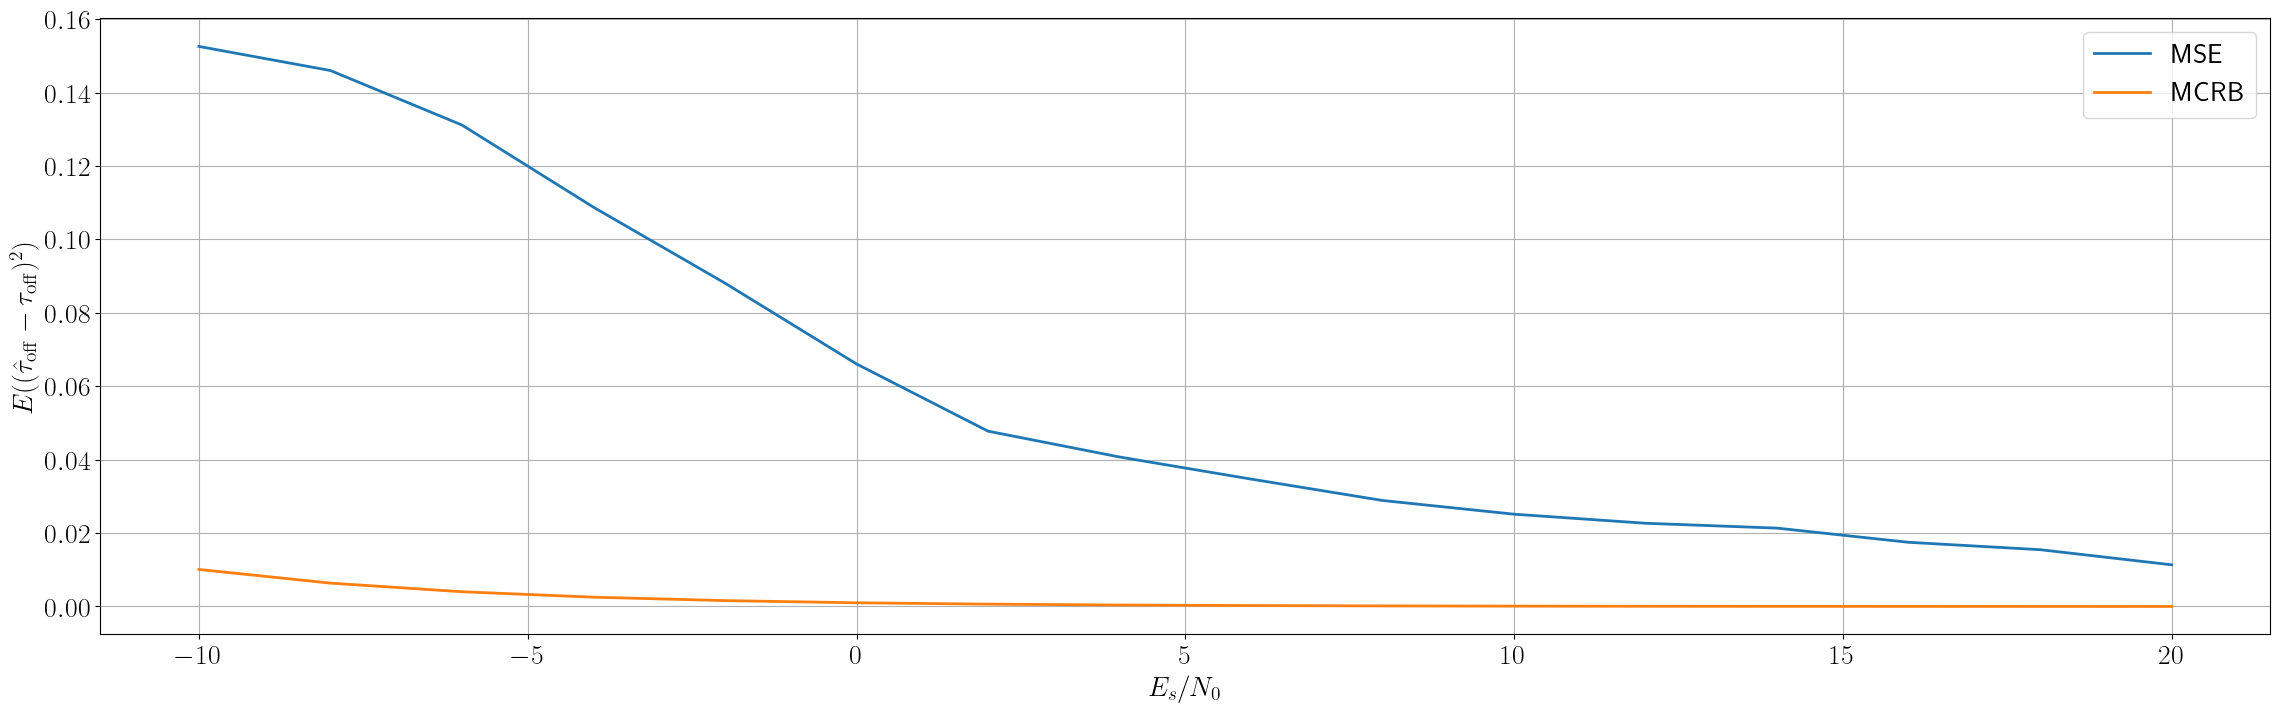

In [8]:
plt.figure()

plt.plot( EsN0_dB, timing_error, linewidth = 2.0, label='MSE' )    
plt.plot( EsN0_dB, MRCB, linewidth = 2.0, label='MCRB' )

plt.grid(True)
plt.xlabel('$E_s/N_0$')
plt.ylabel('$E( ( \hat{\\tau}_{\\mathrm{off}} - \\tau_{\\mathrm{off}} )^2)$')    
plt.legend( loc = 'upper right' )
plt.show()